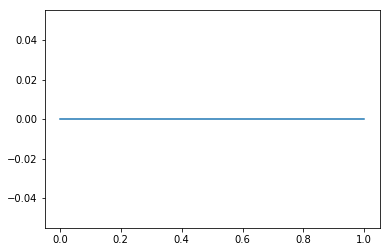

1 10 266
2 10 110
3 10 125


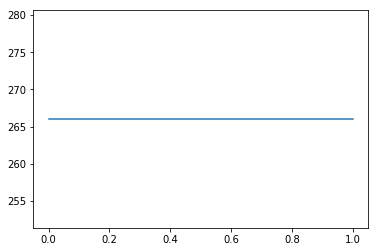

1 5 248
2 5 121
3 0 8


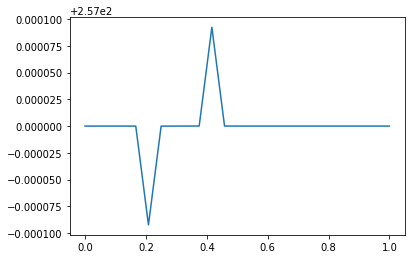

1 10 399
2 4 27
3 10 129


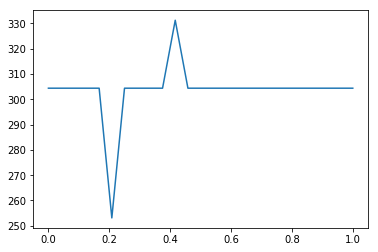

1 0 0
2 5 49
3 10 96


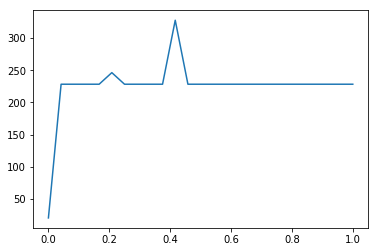

1 10 242
2 10 102
3 1 -1


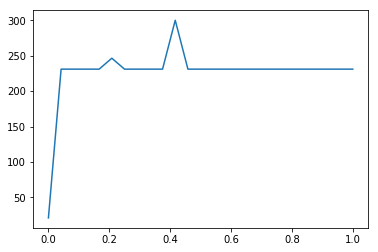

1 10 251
2 5 38
3 9 131


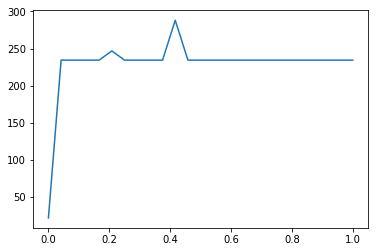

1 10 180
2 5 53
3 9 81


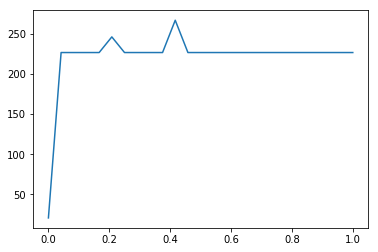

1 5 179
2 10 76
3 9 66


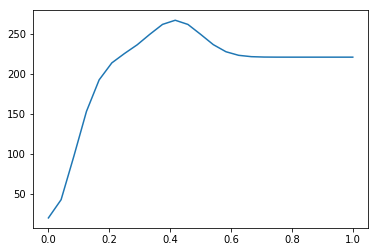

1 9 175
2 5 8
3 10 72


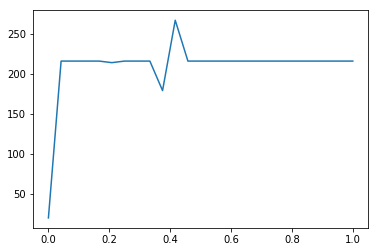

1 10 101
2 5 43
3 9 77


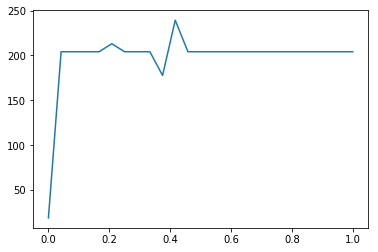

1 5 72
2 10 14
3 9 106


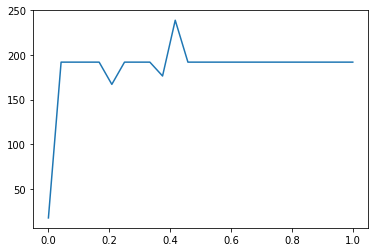

1 10 89
2 0 0
3 11 105


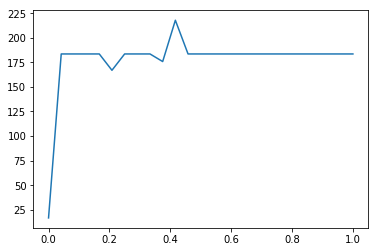

1 10 46
2 5 44
3 9 50


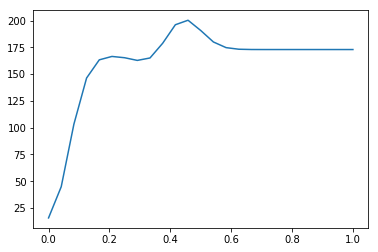

1 10 67
2 5 24
3 9 43


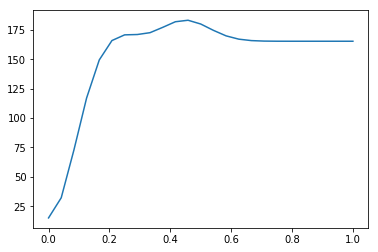

1 5 23
2 9 44
3 10 88


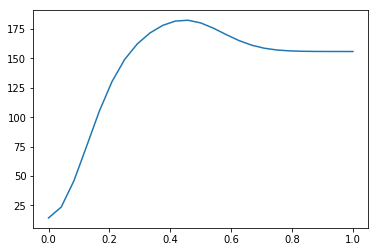

1 9 12
2 5 39
3 10 56


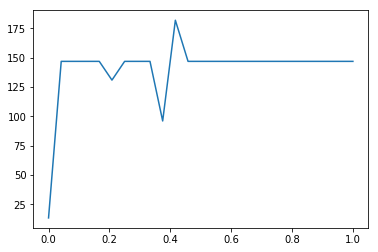

1 10 38
2 1 -1
3 12 78


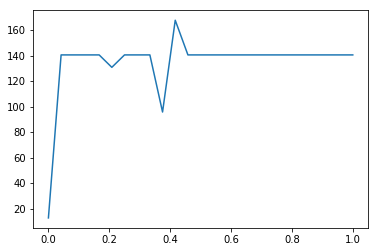

1 10 29
2 5 25
3 9 87


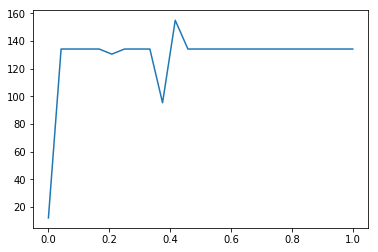

1 5 -1
2 10 40
3 9 106


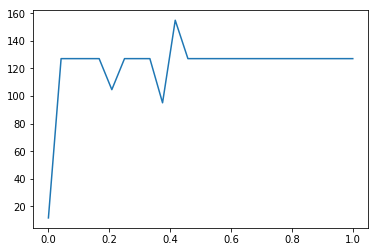

1 10 20
2 5 11
3 9 25
[{1: 10, 2: 10, 3: 10}, {3: 0, 1: 5, 2: 5}, {2: 4, 1: 10, 3: 10}, {1: 0, 2: 5, 3: 10}, {3: 1, 1: 10, 2: 10}, {2: 5, 3: 9, 1: 10}, {2: 5, 3: 9, 1: 10}, {1: 5, 3: 9, 2: 10}, {2: 5, 1: 9, 3: 10}, {2: 5, 3: 9, 1: 10}, {1: 5, 3: 9, 2: 10}, {2: 0, 1: 10, 3: 11}, {2: 5, 3: 9, 1: 10}, {2: 5, 3: 9, 1: 10}, {1: 5, 2: 9, 3: 10}, {2: 5, 1: 9, 3: 10}, {2: 1, 1: 10, 3: 12}, {2: 5, 3: 9, 1: 10}, {1: 5, 3: 9, 2: 10}, {2: 5, 3: 9, 1: 10}, {2: 4, 1: 10, 3: 10}]


In [27]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/federico/Documents/GATTI/DIA_Project/Restart/')

import numpy as np
import matplotlib.pyplot as plt
from bidding_environment import *
from pricing_environment import *
from ts_learner import *
from gpts_learner import *
from data import p
from good_knapsack import *
import math
import pulp


# Sets initial data
n_arms_ads = 25 # number of arms for advertising
n_arms_pricing = 10 # number of arms for pricing

T = 20 # T for Times
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms_ads) # bids are a linspace
sigma = 10

# Presets regrets and rewards that are going to be computed
regrets_per_subcampaign = []
rewards_per_subcampaign = []

price_min = 50.0
price_max = 70.0
prices = np.linspace(price_min, price_max, n_arms_pricing)


ad_envs = [BiddingEnvironment(bids, sigma, subcampaign=subcampaign) for subcampaign in [1,2,3]]
meta_gpts_learners = [GPTS_Learner(n_arms=n_arms_ads, arms=bids) for subcampaign in [1,2,3]]
allocations = [
    {1: 10, 2:10, 3:10}
]

pricing_envs = [PricingEnvironment(n_arms=n_arms_pricing, prices=prices, p=p, subcampaign=subcampaign) for subcampaign in [1,2,3]]
ts_learners = [TS_Learner(n_arms=n_arms_pricing) for subcampaign in [1,2,3]]
for t in range(T):
    # 3 subcampaigns:
    rewards_per_subcampaign = []
    plt.plot(bids, meta_gpts_learners[0].means)
    plt.show()
    for subcampaign in [1, 2, 3]:
        ad_bid_to_try = allocations[-1][subcampaign] # pull the allocated arm
        n_clicks = ad_envs[subcampaign-1].round(ad_bid_to_try) # gets another random value from it
        rewards_from_ad = 0
        for t in range(int(n_clicks)):
            price_to_try = ts_learners[subcampaign-1].pull_arm()
            reward = pricing_envs[subcampaign-1].round(price_to_try)
            rewards_from_ad += reward*price_to_try
            ts_learners[subcampaign-1].update(price_to_try, reward, price_to_try)
        rewards_from_ad -= ad_bid_to_try
        print(subcampaign, ad_bid_to_try, rewards_from_ad)
        meta_gpts_learners[subcampaign-1].update(ad_bid_to_try, rewards_from_ad) # updates the learner
        # Appends to the rewards the values at lower CI
        rewards_per_subcampaign.append(meta_gpts_learners[subcampaign-1].means - meta_gpts_learners[subcampaign-1].sigmas)
    allocations.append(good_knapsack(bids, rewards_per_subcampaign, 1.0))

print(allocations)

In [2]:
import matplotlib.pyplot as plt

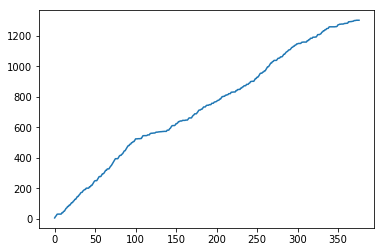

In [11]:
plt.plot(np.cumsum(ts_learners[0].collected_rewards))

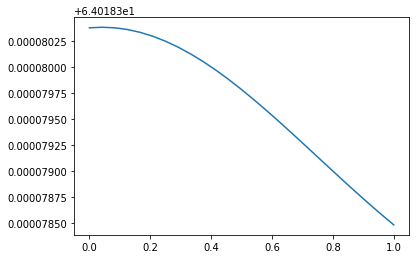

In [9]:
plt.plot(bids, meta_gpts_learners[0].means - meta_gpts_learners[0].sigmas)

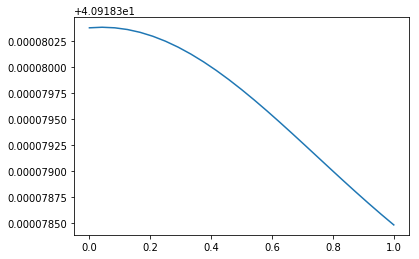

In [7]:
plt.plot(bids, meta_gpts_learners[1].means - meta_gpts_learners[1].sigmas)

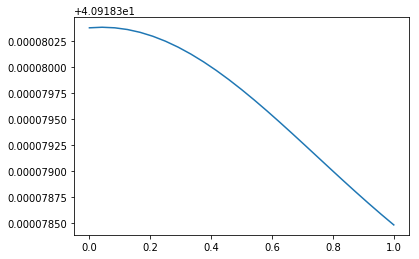

In [8]:
plt.plot(bids, meta_gpts_learners[2].means - meta_gpts_learners[2].sigmas)

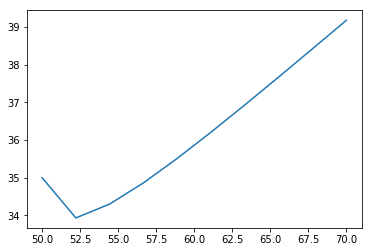

In [26]:
plt.plot(prices, prices*p[1](prices))